# Imaginary Soundscape Demo Code

## Before you try ...

- please download this zipped data file and unzip it into the same directory as this notebook: 
https://github.com/Kajiyu/ImaginarySoundscapeDemo/releases/download/v1.0.0/data.zip

## Additional Information

### References

- Imaginary Soundscape: http://imaginarysoundscape2.qosmo.jp/
- the original demo (Chrome and Firefox are only available.) : http://imaginarysoundscape.qosmo.jp/
- the original paper: https://nips2017creativity.github.io/doc/Imaginary_Soundscape.pdf


### Model
![Model](https://github.com/Kajiyu/ImaginarySoundscapeDemo/raw/master/assets/model.jpg)

### Other references
- Our model is based on MIT's SoundNet: http://soundnet.csail.mit.edu/

## Dependencies

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import shutil
import glob
import json
import collections
import tensorflow as tf
import numpy as np
import librosa
import random
from scipy.stats import entropy

import keras
from keras.models import Model, load_model
import keras.backend as K
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from IPython.display import Audio, Image, display_jpeg, display

Using TensorFlow backend.


## Function Definitions

In [3]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [4]:
def get_image_features(model, filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_image(x)
    preds = model.predict(x)[0]
    return preds

In [10]:
def get_sound_features(model,filepath):
    x, sr = librosa.load(filepath)
    x = x * 255.0
    x = np.reshape(x, (1, x.shape[0], 1, 1))
    x[x < -255.] = -255.
    x[x > 255.] = 255.
    assert np.max(x) < 256., "It seems this audio contains signal that exceeds 256"
    assert np.min(x) > -256., "It seems this audio contains signal that exceeds -256 " + str(np.min(x)) + " : " + filepath
    _y_pred = model.predict(x)
    feature =  _y_pred[0][0][0][0]
    print(feature)
    return feature

In [6]:
def get_topk_songs(img_feature, song_features, k=3):
    distances = []
    for i in range(len(song_features)):
        distance = entropy(img_feature, song_features[i])
        distances.append(distance)
    topk_indecies = np.argsort(distances)[:k]
    return topk_indecies

In [7]:
def create_sound_libs(
    soundnet_model,
    query="./data/sound_samples/*.mp3",
    out_json_path="./data/sounds.json",
    out_npy_path='./data/song_features.npy'
):
    mp3_files = glob.glob(query)
    output_dict = {"mp3":[]}
    for i in range(len(mp3_files)):
        x, sr = librosa.load(mp3_files[i])
        if len(x) > 230000:
            output_dict["mp3"].append({"filepath":mp3_files[i], "index":str(i)})
    with open(out_json_path, "w")  as f:
        json.dump(output_dict, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    song_features = []
    for item in output_dict["mp3"]:
        i_feature = get_sound_features(soundnet_model,item['filepath'])
        song_features.append(i_feature)
    song_features = np.array(song_features)
    print("Sound npy shape:", song_features.shape)
    np.save(out_npy_path, song_features)
    return (output_dict, song_features)

# How to

## 1. Load SoundNet and ImageNet models

In [8]:
soundnet = load_model("./data/models/soundnet.hdf5")
print(soundnet.summary())
imagenet = MobileNet(include_top=True, weights='imagenet') # using MobileNet


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, 1, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 1, 16)  1040        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 1, 16)  64          conv2d_1[0][0]                   
___________________________________________________________________________________________

## 2. Create sound features using SoundNet model

- npy file: features of sounds pre-calculated by SoundNet
- json file: including ...
    - filepath: the path of each sound file
    - index: the index of each sound file at the npy array

In [11]:
# create sound features using SoundNet model
(mp3_files, sound_features) = create_sound_libs(soundnet)

print("#of mp3 files", len(mp3_files['mp3']))


[4.91410829e-05 5.45736111e-04 6.64249179e-04 1.50629188e-04
 3.11097305e-04 1.43010679e-04 1.88816237e-04 3.76500277e-04
 1.68037732e-04 1.85414858e-04 5.86266833e-05 2.70570716e-04
 1.65409670e-04 1.58590483e-04 2.83456204e-04 1.02118312e-04
 1.39084616e-04 1.50415595e-04 2.39084999e-04 9.42608021e-05
 6.95642302e-05 3.39401013e-04 3.72899551e-04 4.94802080e-04
 8.56028419e-05 3.84308660e-05 1.56391514e-04 5.90957970e-05
 7.28377781e-05 2.56328494e-04 4.07346452e-05 1.06282896e-04
 5.17544031e-05 1.29878215e-04 1.97374306e-04 8.05816453e-05
 2.51810328e-04 1.98435664e-05 7.11466928e-05 1.03684506e-04
 1.17550240e-04 3.35785844e-05 4.91566898e-05 2.58812597e-05
 8.90659503e-05 4.54867477e-05 1.14243361e-04 6.23135784e-05
 3.60790218e-05 6.67551722e-05 2.43207309e-04 5.48822805e-04
 4.28132043e-05 4.82151991e-05 3.15738071e-05 1.13833790e-04
 4.06788640e-05 3.35099321e-05 2.95730744e-04 1.53378540e-04
 1.88120655e-04 7.07703075e-05 3.65194210e-05 4.00986428e-05
 1.05646250e-04 1.64832

[2.11667269e-04 7.63700868e-04 5.21667418e-04 1.89990998e-04
 6.19642204e-04 2.03250573e-04 7.83354044e-04 5.94939920e-04
 1.67737468e-04 8.81397063e-05 4.44133548e-05 7.11032990e-05
 7.72003332e-05 7.12767578e-05 5.66203562e-05 4.72384309e-05
 5.84368208e-05 7.14191410e-05 1.34995862e-04 1.04903331e-04
 6.71002635e-05 8.94632612e-05 8.47966367e-05 3.12501012e-04
 9.10425952e-05 5.59905493e-05 7.94232692e-05 7.55087531e-05
 8.11321152e-05 6.34749071e-04 3.87467371e-05 1.01799982e-04
 6.52405870e-05 3.84452986e-04 3.65603570e-04 5.31060177e-05
 2.04645039e-04 4.86788485e-05 1.46857201e-04 1.29399225e-04
 6.65006664e-05 5.02762668e-05 4.53119683e-05 9.34317504e-05
 4.86000390e-05 1.13617374e-04 8.20964196e-05 8.89803850e-05
 7.50628824e-05 8.11470018e-05 2.14636297e-04 1.12826785e-03
 8.30557110e-05 6.63547398e-05 8.08767945e-05 1.03859151e-04
 1.12546295e-04 2.58238542e-05 1.35345268e-04 2.02449970e-04
 3.49767943e-04 3.78257682e-04 1.71062435e-04 3.63099680e-04
 1.53107685e-04 1.704670

[2.76470761e-04 8.68345436e-04 9.57353041e-04 3.96758696e-04
 1.22674846e-03 7.66176905e-04 1.75300520e-03 5.42003429e-04
 5.60922839e-04 7.41798314e-04 3.39497288e-04 6.00057363e-04
 6.54832809e-04 6.63988641e-04 5.40280773e-04 5.12264727e-04
 4.76194895e-04 6.65546453e-04 1.11657951e-03 3.22292093e-04
 8.48238065e-04 1.38384174e-03 1.02841959e-03 1.42463588e-03
 5.95465477e-04 2.02707233e-04 5.12998493e-04 3.19710525e-04
 1.78195754e-04 7.29982683e-04 3.05968337e-04 3.50101240e-04
 4.51221771e-04 7.70280312e-04 1.80025410e-03 4.61760530e-04
 7.66548968e-04 2.10963379e-04 4.28777770e-04 3.95926938e-04
 3.54850286e-04 4.02091508e-04 4.88748075e-04 2.02545780e-04
 3.23437678e-04 2.36475709e-04 4.35170688e-04 1.79903553e-04
 2.02205512e-04 4.50970110e-04 1.19934930e-03 4.11806279e-04
 4.19099873e-04 3.03762034e-04 3.08278715e-04 2.96408485e-04
 2.01474060e-04 2.32669903e-04 1.57368905e-03 4.10789566e-04
 4.10764507e-04 1.89186161e-04 2.03038755e-04 2.76564911e-04
 2.75826053e-04 5.070400

[8.29054683e-04 7.06988503e-04 8.60921631e-04 2.53452890e-04
 7.64191966e-04 2.63587252e-04 9.39836958e-04 6.26474095e-04
 2.37971079e-04 6.53306197e-04 6.58737845e-05 9.94401344e-05
 1.04021768e-04 1.61996039e-04 8.67871713e-05 9.24044216e-05
 8.26460309e-05 1.23694539e-04 3.33752687e-04 1.23542690e-04
 2.31508064e-04 3.67201661e-04 3.03979934e-04 6.84217259e-04
 1.78497459e-04 1.28603686e-04 1.29530032e-04 1.17461503e-04
 1.17387142e-04 4.57054179e-04 6.07623915e-05 1.30236018e-04
 1.06797233e-04 6.86422572e-04 1.07198337e-03 1.11819274e-04
 3.00027721e-04 5.60758381e-05 1.45516809e-04 2.44258088e-04
 7.49157116e-05 7.26118305e-05 9.48382149e-05 9.45336797e-05
 6.65668485e-05 1.55861169e-04 8.19703419e-05 6.96895077e-05
 1.21991812e-04 1.89146624e-04 4.38191986e-04 8.68309464e-04
 1.13460163e-04 1.03445214e-04 8.99617589e-05 9.80700133e-05
 9.22864056e-05 4.10497159e-05 3.18838574e-04 2.63342663e-04
 3.02902685e-04 3.62473103e-04 2.46082403e-04 3.61879036e-04
 1.32970075e-04 2.862713

[3.01367923e-04 7.08951615e-04 7.87535973e-04 3.50557326e-04
 7.87493540e-04 5.43709961e-04 8.01504299e-04 7.40221411e-04
 8.66063230e-04 1.39349280e-03 1.70775189e-03 2.23842799e-03
 2.68458691e-03 2.32654484e-03 1.91554672e-03 2.95665790e-03
 2.57522915e-03 1.71051058e-03 3.33695533e-03 1.18627131e-03
 1.91776932e-03 7.34771788e-03 3.90669703e-03 4.23276844e-03
 3.17200669e-03 2.53508799e-04 5.57770312e-04 3.08684306e-04
 1.82756863e-04 5.22099552e-04 4.21518635e-04 6.24121225e-04
 6.69264642e-04 3.97240045e-04 7.66406709e-04 6.87323976e-04
 7.89769401e-04 4.42476536e-04 3.49057227e-04 5.74839010e-04
 6.65419269e-04 5.21448092e-04 7.83922733e-04 3.47406254e-04
 4.01351688e-04 3.02445667e-04 7.90683029e-04 3.09049210e-04
 3.02595407e-04 7.25071179e-04 1.96593953e-03 3.83597857e-04
 4.96004126e-04 3.01610678e-04 2.75458209e-04 5.40382462e-04
 1.63197124e-04 2.67157331e-04 1.49024022e-03 6.49410009e-04
 3.25561559e-04 1.89689788e-04 2.23827956e-04 2.79657572e-04
 5.54166792e-04 3.431901

[5.01025643e-05 3.95511539e-04 4.51353553e-04 1.76437228e-04
 4.92320396e-04 1.28165775e-04 3.64473497e-04 4.19599673e-04
 5.07535988e-05 4.22724079e-05 2.45510200e-05 4.42528399e-05
 4.73587716e-05 4.72665452e-05 5.00026581e-05 2.66345851e-05
 3.86714637e-05 5.60132466e-05 5.58147731e-05 7.37892406e-05
 3.74959673e-05 5.46161536e-05 6.69852307e-05 1.09006542e-04
 2.34667714e-05 1.50800233e-05 3.31377305e-05 3.40164006e-05
 4.10806897e-05 2.71087716e-04 2.01895036e-05 5.97017206e-05
 3.25660185e-05 2.49813573e-04 1.71752079e-04 2.35277221e-05
 9.38430094e-05 1.28297606e-05 5.02345210e-05 3.73582807e-05
 4.52582390e-05 1.56175101e-05 1.70008843e-05 2.87818966e-05
 2.05688375e-05 3.94352028e-05 3.52063507e-05 3.42428393e-05
 2.03473664e-05 2.46827803e-05 7.50955660e-05 1.98359904e-03
 3.02188964e-05 2.96934231e-05 3.72303657e-05 4.94758970e-05
 4.10498469e-05 1.27254398e-05 5.09704696e-05 1.46583086e-04
 2.10250393e-04 1.42200472e-04 6.20079882e-05 1.25205479e-04
 8.21849317e-05 7.118230

[1.40915610e-04 8.70921416e-04 8.22764006e-04 4.85993573e-04
 1.00014708e-03 3.71916278e-04 1.40234677e-03 6.90460205e-04
 2.27483310e-04 2.94978963e-04 8.62523157e-05 1.79847149e-04
 1.94808978e-04 1.81304204e-04 1.87802914e-04 1.27494903e-04
 1.50217253e-04 2.22380084e-04 3.21914617e-04 2.36532680e-04
 1.39848460e-04 1.45389509e-04 1.72669956e-04 4.63449833e-04
 1.19563818e-04 5.85364032e-05 1.07032036e-04 6.03858498e-05
 6.42066952e-05 6.31265633e-04 8.65618640e-05 1.37537136e-04
 1.06266627e-04 6.09845505e-04 3.20649036e-04 1.48412670e-04
 5.78345731e-04 1.00830373e-04 1.00129226e-04 3.53052485e-04
 9.51172624e-05 5.19446985e-05 6.50018410e-05 8.57868145e-05
 5.10980535e-05 1.09847846e-04 1.25414488e-04 1.20602046e-04
 3.11528973e-04 1.89962229e-04 6.56570191e-04 1.51737500e-03
 8.31276484e-05 6.85253544e-05 8.33198719e-05 1.57383489e-04
 9.02007814e-05 3.94672388e-05 2.44924129e-04 2.07609919e-04
 2.25484109e-04 3.18464416e-04 1.71641208e-04 3.05022957e-04
 2.46275798e-04 2.765707

[1.22099766e-04 1.02188229e-03 5.41758374e-04 3.08318326e-04
 1.09976437e-03 3.83045495e-04 6.87598600e-04 6.39447186e-04
 6.30846655e-04 2.07498524e-04 1.71627325e-04 2.96092971e-04
 2.50190991e-04 2.66549032e-04 2.00560651e-04 1.54675829e-04
 2.75554543e-04 2.88729381e-04 4.25414939e-04 2.87873205e-04
 1.46136867e-04 2.84613838e-04 2.01774950e-04 4.69680032e-04
 2.30034711e-04 1.19236807e-04 1.92942694e-04 1.33410955e-04
 1.45885031e-04 1.34549022e-03 9.21058963e-05 2.64924165e-04
 1.69296662e-04 3.77137476e-04 3.93301016e-04 1.46740233e-04
 4.09023953e-04 1.12519832e-04 4.04255959e-04 1.39929194e-04
 1.46578415e-04 8.76975391e-05 1.05400373e-04 1.11847105e-04
 9.88518150e-05 1.65195452e-04 1.70123632e-04 1.92473861e-04
 7.55011133e-05 9.63081766e-05 2.07317353e-04 8.59902881e-04
 1.48174469e-04 1.20267956e-04 9.83836871e-05 1.87274796e-04
 2.49101780e-04 7.73801585e-05 1.79468945e-04 2.76618521e-04
 3.03957466e-04 2.87843024e-04 1.50979351e-04 3.44423170e-04
 3.57825775e-04 2.695270

[1.43735451e-05 4.15978022e-04 4.94879379e-04 2.97911727e-04
 9.97224357e-04 2.39747096e-04 3.63327126e-04 2.38772423e-04
 2.48760789e-05 1.67128637e-05 8.89715193e-06 1.78977571e-05
 2.14782904e-05 1.53809669e-05 1.83981101e-05 1.37208008e-05
 1.72008149e-05 1.90802457e-05 2.42944952e-05 1.81035830e-05
 8.64731464e-06 3.30522344e-05 4.36441369e-05 7.45094367e-05
 9.33201773e-06 1.26492387e-05 2.36021569e-05 1.21505091e-05
 2.76123574e-05 1.08557615e-04 1.19996093e-05 4.09980785e-05
 2.34728850e-05 1.80183677e-04 1.62715951e-04 1.93778524e-05
 7.29423846e-05 5.77494666e-06 1.89480907e-05 1.92419648e-05
 1.68895604e-05 6.05298055e-06 1.08713266e-05 1.64731609e-05
 1.03037855e-05 3.83636107e-05 2.27787950e-05 2.75233360e-05
 9.70990914e-06 1.01004744e-05 3.12074844e-05 1.01518258e-03
 1.12154248e-05 1.60049967e-05 1.81507439e-05 4.27843988e-05
 2.37516379e-05 6.07608035e-06 2.76868213e-05 1.02388265e-04
 1.57562230e-04 2.66918269e-05 1.97631925e-05 5.55735423e-05
 5.54151702e-05 1.139290

[3.65309446e-04 8.32649530e-04 2.84419605e-03 1.70075544e-03
 3.13555170e-03 1.88139908e-03 2.55274936e-03 5.32726874e-04
 7.60637631e-04 1.50260294e-03 5.25147363e-04 3.77690390e-04
 5.76374179e-04 9.15684155e-04 4.67486941e-04 6.31981296e-04
 4.91416547e-04 6.05973706e-04 1.71113154e-03 6.57177705e-04
 1.02182745e-03 2.16106628e-03 1.67700613e-03 2.17614975e-03
 8.76516511e-04 2.13444931e-04 4.87845507e-04 2.70911900e-04
 1.26810890e-04 8.45823786e-04 3.42586893e-04 3.95788928e-04
 4.47000813e-04 1.70096487e-03 1.25749712e-03 5.13697334e-04
 7.95247266e-04 1.71782827e-04 3.96081945e-04 4.99349146e-04
 2.69232347e-04 3.13024677e-04 3.19800311e-04 2.62760441e-04
 2.20783768e-04 2.64681556e-04 2.72632868e-04 3.16545396e-04
 3.26967594e-04 8.44853756e-04 1.28637347e-03 6.42434228e-04
 3.10976960e-04 2.30324848e-04 2.69678450e-04 2.46691605e-04
 1.61189077e-04 1.58323877e-04 1.63135806e-03 3.49108508e-04
 2.91771081e-04 1.78487608e-04 2.47191696e-04 2.76443578e-04
 3.07324633e-04 1.913696

[6.62434264e-04 6.84768369e-04 1.09718740e-03 3.84390150e-04
 9.41957755e-04 8.79102095e-04 1.53236522e-03 6.37258869e-04
 8.10224679e-04 2.08980078e-03 3.92709568e-04 6.40409824e-04
 9.06789210e-04 7.62408483e-04 5.91674529e-04 5.59006527e-04
 5.08782512e-04 7.36561022e-04 2.22318945e-03 3.68822075e-04
 1.03804667e-03 2.59804423e-03 2.20974837e-03 2.39302870e-03
 1.14762504e-03 2.24690652e-04 4.51140775e-04 3.86796339e-04
 1.50522596e-04 3.42976826e-04 3.29020608e-04 3.60927777e-04
 4.38313378e-04 8.76145728e-04 1.78705901e-03 5.07992692e-04
 1.02668046e-03 2.86864000e-04 3.14534147e-04 6.07936003e-04
 3.10624775e-04 3.81877006e-04 6.88128290e-04 3.00640502e-04
 3.02554341e-04 3.84298677e-04 4.09894914e-04 2.76306760e-04
 4.97739122e-04 1.10446895e-03 2.07621255e-03 5.47575182e-04
 4.55638627e-04 2.56580039e-04 3.30708019e-04 3.32488737e-04
 1.87452679e-04 2.64884147e-04 1.79182074e-03 4.23547521e-04
 3.09307710e-04 1.96809124e-04 2.94315570e-04 3.68868874e-04
 3.52949864e-04 7.863444

[9.32724652e-05 2.84747104e-04 2.55798834e-04 1.37706258e-04
 4.24233120e-04 1.35925904e-04 3.64683336e-04 4.34542279e-04
 1.64923418e-04 3.16939957e-04 8.44875831e-05 1.47846062e-04
 1.58444367e-04 1.82454547e-04 1.41443466e-04 1.34023430e-04
 1.18231503e-04 1.53209839e-04 2.82230758e-04 1.59339703e-04
 1.09742577e-04 2.76340725e-04 2.98168336e-04 6.03455293e-04
 1.89458457e-04 5.40247056e-05 7.89958576e-05 4.88267651e-05
 4.42507480e-05 2.79460568e-04 5.30967700e-05 9.97208408e-05
 5.39915927e-05 1.42114717e-04 2.47327582e-04 7.73661959e-05
 2.54244602e-04 7.55293731e-05 5.63469766e-05 1.47112994e-04
 9.20490274e-05 4.94531341e-05 9.19066588e-05 6.01066786e-05
 4.88660080e-05 1.04014260e-04 1.03731494e-04 8.77539205e-05
 1.37232913e-04 2.26487668e-04 4.89864848e-04 1.02393911e-03
 5.59883301e-05 4.11099645e-05 6.59098150e-05 1.03106788e-04
 6.28875641e-05 3.05891335e-05 1.73761888e-04 1.43839294e-04
 1.64524492e-04 2.24873482e-04 1.35234935e-04 1.27298626e-04
 1.07281441e-04 6.523585

[1.29847103e-04 5.83879999e-04 1.20923261e-03 5.02821465e-04
 8.84178735e-04 3.94177623e-04 7.89968821e-04 3.00116575e-04
 2.08270139e-04 2.66899937e-04 7.68965110e-05 1.05628496e-04
 1.36668648e-04 1.30881468e-04 1.38291784e-04 1.13808361e-04
 9.86207524e-05 1.85971134e-04 2.64390896e-04 1.39777098e-04
 2.73593410e-04 1.99262155e-04 2.64046423e-04 3.74447292e-04
 1.90560866e-04 3.70622074e-05 1.10944115e-04 4.27571867e-05
 4.20469951e-05 3.44860484e-04 6.15890822e-05 1.02088401e-04
 5.67243223e-05 4.55833389e-04 3.43305903e-04 8.26437463e-05
 2.43550734e-04 2.73797377e-05 7.29140083e-05 1.04083236e-04
 7.72974017e-05 2.56937710e-05 4.57255810e-05 3.19410574e-05
 3.64006519e-05 8.78801438e-05 8.53489400e-05 4.88989535e-05
 4.78951188e-05 1.26404528e-04 3.10783769e-04 5.27700933e-04
 4.40371477e-05 4.31210865e-05 3.89543529e-05 8.93169345e-05
 3.99723467e-05 2.26794182e-05 3.18394508e-04 1.41317825e-04
 1.32758345e-04 7.86553283e-05 6.21377840e-05 1.00882520e-04
 1.10437832e-04 2.008545

[2.97917868e-04 2.31680949e-03 1.82328420e-03 1.73203147e-03
 3.65159032e-03 1.61997229e-03 5.05909417e-03 5.14689309e-04
 2.52915808e-04 3.69018788e-04 1.05172810e-04 2.45821750e-04
 2.09357167e-04 2.66745657e-04 2.99647887e-04 2.24153278e-04
 1.64676341e-04 2.95690261e-04 4.16213239e-04 2.07933990e-04
 4.51827829e-04 2.17806140e-04 3.29536764e-04 7.88848032e-04
 3.20675463e-04 1.87915779e-04 3.60702106e-04 1.63123361e-04
 1.21594188e-04 1.23054557e-03 3.20004590e-04 2.07655947e-04
 3.56101198e-04 2.74677924e-03 9.19518003e-04 5.59415261e-04
 1.61685003e-03 2.88775860e-04 2.69611890e-04 8.39263434e-04
 1.84944380e-04 3.31761432e-04 2.38775770e-04 3.40995757e-04
 1.79611699e-04 1.90211111e-04 2.64006812e-04 2.84254871e-04
 8.43244139e-04 6.18227641e-04 1.87741220e-03 9.15371696e-04
 2.07541700e-04 1.17309341e-04 2.14133775e-04 2.87041941e-04
 1.31291599e-04 1.41409997e-04 9.54856689e-04 3.01081134e-04
 3.35342076e-04 5.55486185e-04 5.63373149e-04 4.22408892e-04
 3.18759296e-04 7.046293

[5.70540396e-05 2.99994514e-04 2.10847866e-04 8.90338561e-05
 2.71074125e-04 1.20375640e-04 1.63262128e-04 4.29773907e-04
 7.96111781e-05 9.73894930e-05 3.60581107e-05 7.95843807e-05
 7.20696407e-05 5.47046948e-05 6.40193612e-05 4.90455277e-05
 7.22085460e-05 7.75883818e-05 9.84107173e-05 6.03001718e-05
 2.22563613e-05 1.48694264e-04 1.41438824e-04 2.62905407e-04
 5.52203092e-05 2.75090315e-05 3.63043036e-05 3.54793810e-05
 3.89894558e-05 1.33685680e-04 2.12469531e-05 6.44286847e-05
 2.99668664e-05 7.52734268e-05 1.75033972e-04 2.73596652e-05
 7.83166979e-05 1.58817456e-05 5.82894063e-05 4.10045977e-05
 4.57848291e-05 2.57736265e-05 3.31205119e-05 3.85166568e-05
 1.96942710e-05 6.22727748e-05 4.85122400e-05 4.78724833e-05
 3.07445516e-05 2.00290178e-05 6.88857181e-05 1.24213647e-03
 3.24875255e-05 4.10093307e-05 4.51262313e-05 5.28736564e-05
 4.24096797e-05 2.25312797e-05 3.84973791e-05 1.56185240e-04
 1.74651141e-04 9.26118228e-05 6.39598074e-05 1.20280514e-04
 8.17310574e-05 9.115323

[2.72623438e-04 2.89281597e-03 2.74428632e-03 1.44149899e-03
 3.39969411e-03 1.46487006e-03 3.67806409e-03 5.91174758e-04
 3.59672675e-04 4.33710520e-04 1.55238784e-04 2.47634540e-04
 2.18997884e-04 2.65909679e-04 3.17059079e-04 2.34047169e-04
 1.99511778e-04 3.17476806e-04 4.77638590e-04 2.42871829e-04
 5.54250902e-04 3.55019758e-04 3.40808067e-04 6.68896420e-04
 3.80630430e-04 2.62559974e-04 4.30090004e-04 2.41509086e-04
 1.78837377e-04 1.85287290e-03 2.24424963e-04 3.02935165e-04
 2.46924552e-04 1.84698263e-03 1.01130852e-03 3.85507767e-04
 1.19189185e-03 1.00399877e-04 2.80045671e-04 3.63478146e-04
 2.15897177e-04 1.24395141e-04 1.73139182e-04 1.57632618e-04
 1.26828891e-04 1.94001390e-04 2.64697621e-04 2.53601669e-04
 3.72537383e-04 4.40180796e-04 9.97086521e-04 6.00105966e-04
 1.89901650e-04 1.65530480e-04 1.55876245e-04 2.88337120e-04
 1.90724022e-04 1.20393022e-04 7.57735805e-04 3.58313526e-04
 3.26693727e-04 1.92636726e-04 2.11703882e-04 3.41797888e-04
 3.49617389e-04 1.559151

KeyboardInterrupt: 

or

In [9]:
# or, load pre-processed json data
with open("./data/sounds.json") as f:
    mp3_files = json.load(f)
sound_features = np.load("./data/song_features.npy")

print(sound_features)

[[4.9141083e-05 5.4573611e-04 6.6424918e-04 ... 1.7505941e-05
  1.9200075e-04 2.2384794e-04]
 [4.6414937e-04 2.6032405e-03 3.1171141e-03 ... 2.3361320e-04
  7.4550416e-04 3.4542065e-04]
 [2.1166727e-04 7.6370087e-04 5.2166742e-04 ... 7.4240714e-05
  8.2111335e-04 1.6795333e-03]
 ...
 [4.5079792e-05 5.1000179e-04 3.2997000e-04 ... 2.0178722e-05
  2.8103183e-04 9.2700782e-04]
 [9.9715358e-04 6.0654979e-04 5.0324807e-04 ... 1.6577366e-04
  8.4309821e-04 8.4084942e-04]
 [1.7563436e-04 2.4039762e-03 1.6111756e-02 ... 1.4785051e-04
  1.9167998e-04 2.0118526e-04]]


## 3. Find the best-matched sound files for an input image

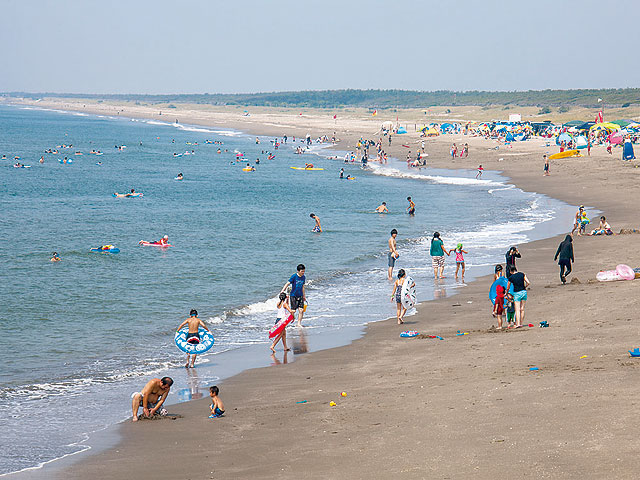

In [15]:
IMG_PATH = "./data/image_samples/sea.jpg"
display_jpeg(Image(IMG_PATH))

In [16]:
# Extract image features using ImageNet model(MobileNet)
img_feature = get_image_features(imagenet, IMG_PATH)

# Match the image features and pre-processed sound features,
# then find the topK best matched sound files 
topk_indecies = get_topk_songs(img_feature, sound_features, k=3)

In [17]:
print("The best-matched sound:")
print

for i in range(3):
    print("Top #", i)
    display(Audio(mp3_files["mp3"][topk_indecies[i]]["filepath"]))

The best-matched sound:
Top # 0


Top # 1


Top # 2
